<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%EC%95%84%ED%8C%8C%ED%8A%B8%EA%B0%80%EA%B2%A9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import scipy
from scipy.linalg import cholesky

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [37]:
#!git clone https://github.com/hongjai-rhee/public.git
## 데이터 불러오기  
data = pd.read_csv('gangnam1.csv')   ## 서울 강남구 아파트 매매가격과 전세가격 (2015년 1월~2020년 10월)

data=data.dropna()
data.head()    # 결측치 제거

,year,p1,p2,date
0,2015.1,72.876565,88.001864,-1
1,2.0,73.041837,88.438477,0
2,3.0,73.533548,89.251973,1
3,4.0,73.865811,90.161722,2
4,5.0,74.234214,90.719040,3


In [38]:

data["change_1"] = np.log(data["p1"]).diff()
data["change_2"] = np.log(data["p2"]).diff()
data = data.dropna()
data.head()



,year,p1,p2,date,change_1,change_2
1,2.0,73.041837,88.438477,0,0.002265,0.004949
2,3.0,73.533548,89.251973,1,0.006709,0.009156
3,4.0,73.865811,90.161722,2,0.004508,0.010141
4,5.0,74.234214,90.719040,3,0.004975,0.006162
5,6.0,74.854512,91.328642,4,0.008321,0.006697


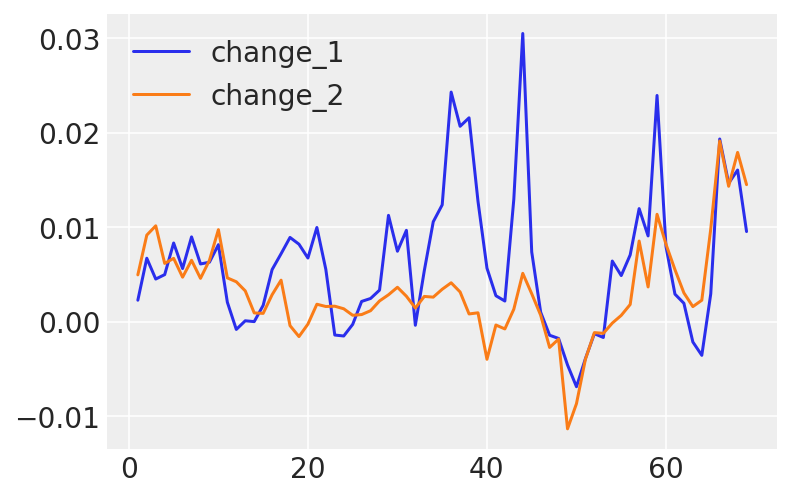

In [50]:

data.plot(y=["change_1", "change_2"])  # 1=매매가 상승률, 2=전세가 상승율


In [40]:

y=data.change_2
x=data.change_1
date=data.date
T = len(y)   

mod = pm.Model()
with mod:
    CP = pm.DiscreteUniform('changepoint', np.min(date), np.max(date))    
    a = pm.Normal('a', mu=0, sd=10, shape=2)
    b = pm.Normal('b', mu=0, sd=10, shape=2)
    sig = pm.HalfCauchy('sig', 2.5,  shape=2)

    y_mean0 = a[0] + b[0]*x.values
    y_mean1 = a[1] + b[1]*x.values
   
    grp = (date.values > CP) * 1

    y_mean = grp*y_mean1 + (1-grp)*y_mean0
    sigma=grp*sig[1]+(1-grp)*sig[0]
    like = pm.Normal('likelihood', mu=y_mean, sd=sigma ,  observed = y.values)

In [41]:
with mod:
  trace = pm.sample(draws=2000, tune=2000, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [changepoint]
>NUTS: [sig, b, a]
Sampling chain 0, 0 divergences:  29%|██▉       | 1167/4000 [00:04<00:04, 586.00it/s]/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:  29%|██▉       | 1167/4000 [00:05<00:12, 232.43it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [36]:
pm.summary(trace)

/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:145: SyntaxWarning: More chains (2000) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_sh

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
changepoint,44.742,1.162,43.000,47.000,0.054,0.038,458.0,458.0,461.0,517.0,NaN
a[0],0.002,0.001,0.001,0.004,0.000,0.000,1631.0,1631.0,1626.0,1504.0,NaN
a[1],0.000,0.001,-0.002,0.002,0.000,0.000,1255.0,957.0,1256.0,1212.0,NaN
b[0],0.062,0.069,-0.072,0.186,0.002,0.001,1834.0,1471.0,1831.0,1623.0,NaN
b[1],0.815,0.122,0.573,1.029,0.003,0.002,1263.0,1250.0,1278.0,1201.0,NaN
sig[0],0.003,0.000,0.002,0.004,0.000,0.000,1798.0,1734.0,1859.0,1478.0,NaN
sig[1],0.005,0.001,0.003,0.006,0.000,0.000,1458.0,1372.0,1596.0,1413.0,NaN


/usr/local/lib/python3.6/dist-packages/arviz/data/base.py:145: SyntaxWarning: More chains (2000) than draws (2). Passed array should have shape (chains, draws, *shape)
  SyntaxWarning,
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


IndexError: ignored

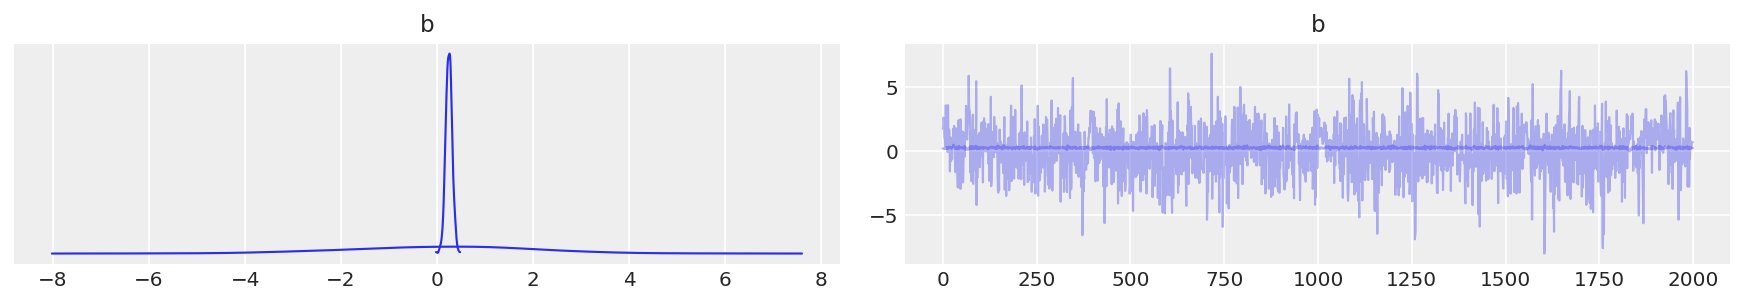

In [11]:
pm.traceplot(trace, var_names="b")